# Matplotlib: Neat tricks

This notebook contains utility functions to

- Add panel labels (A, B, C, ...)
- Connect areas on vertically stacked axes
- Draw beeswarm plots
- Draw rainbow coloured lines (it made sense at the time)

## Semi-automatic panel labels

We often want to add some letters (A, B, etc.) to our panels so that we can refer to them more easily in the caption and text.
This can be done manually, but we can also mess with transformations to make this a semi-automatic process.

In [10]:
def axletter(axes, letter, offset=-0.05, tweak=0,
             weight='bold', fontsize=14, ha='center'):
    """
    Draw a letter (e.g. "A") near the top left of an axes system.

    Arguments:

    ``axes``
        The axes to label.
    ``letter``
        The letter (or text) to label the axes with.
    ``offset``
        An x offset, specified in figure coordinates. Using figure coordinates
        lets you align labels for different axes.
    ``tweak``
        An optional y coordinate tweak (in figure coordinates).
    ``weight``
        The font weight (default: bold)
    ``fontsize``
        The font size (default: 14)
    ``ha``
        Horizontal alignment (default: center)

    """
    # Get top of axes, in figure coordinates
    trans = axes.transAxes
    x, y = trans.transform((0, 1))
    trans = axes.get_figure().transFigure
    x, y = trans.inverted().transform((x, y))

    font = dict(weight=weight, fontsize=fontsize)
    axes.text(x + offset, y + tweak, letter, font, ha=ha, va='top',
              transform=trans)

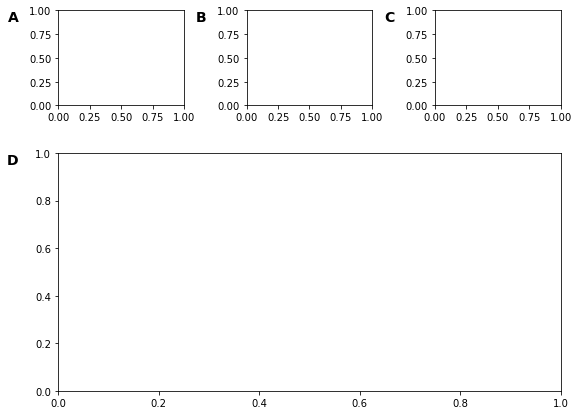

In [19]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9, 7))
grid = fig.add_gridspec(3, 3, wspace=0.5, hspace=0.5)

ax00 = fig.add_subplot(grid[0, 0])
axletter(ax00, 'A', offset=-0.07)

ax01 = fig.add_subplot(grid[0, 1])
axletter(ax01, 'B', offset=-0.07)

ax02 = fig.add_subplot(grid[0, 2])
axletter(ax02, 'C', offset=-0.07)

ax10 = fig.add_subplot(grid[1:, :])
axletter(ax10, 'D', offset=-0.07)

plt.show()

This aligns the top of the letter with the top of the axes, so it looks nicest if y ticks (or limits) are chosen to stay within that range too:

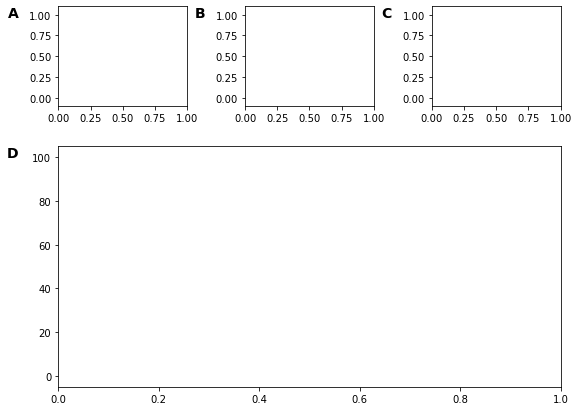

In [23]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9, 7))
grid = fig.add_gridspec(3, 3, wspace=0.45, hspace=0.4)

ax00 = fig.add_subplot(grid[0, 0])
ax00.set_ylim(-0.1, 1.1)
axletter(ax00, 'A', offset=-0.07)

ax01 = fig.add_subplot(grid[0, 1])
ax01.set_ylim(-0.1, 1.1)
axletter(ax01, 'B', offset=-0.07)

ax02 = fig.add_subplot(grid[0, 2])
ax02.set_ylim(-0.1, 1.1)
axletter(ax02, 'C', offset=-0.07)

ax10 = fig.add_subplot(grid[1:, :])
ax10.set_ylim(-5, 105)
axletter(ax10, 'D', offset=-0.07)

plt.show()

## Connecting areas on vertically stacked axes

This example shows how to connect areas on two different axes, where one set of axes is located above the other.
We can use this to create "zoom" panels, as an alternative to insets.

Understanding the code requires a bit of a deep-dive into transformations.
Specifically, we
- Transform points on two different axes to display coordinates.
- Immediately untransform those display coordinates to coordinates relative to a single axes (because display coordinates can change)
- Draw a shape between the coordinates

In [1]:
import matplotlib

def vconnect(axhi, axlo, xhi, xlo=None,
             facecolor='#f0f0f0', edgecolor='#e0e0e0',
             shadehi=False, shadelo=False):
    """
    Draw region connecting the same times on axes ``axhi`` and ``axlo``, where
    ``axhi`` is situatated above ``axlo``.

    Arguments:

    ``axhi``
        Axes, must be situated above ``axlo``.
    ``axlo``
        Axes, must be situated below ``axhi``.
    ``xhi``
        A tuple ``(x1, x2)`` indicating the region (in data coordinates) to
        connect. By default, the region is drawn from ``(x1, x2)`` on ``axhi``
        to ``(x1, x2)`` on ``axlo``.
    ``xlo``
        An optional tuple indicating alternative points on ``axlo`` to draw the
        region to.
    ``facecolor``, ``edgecolor``
        Face and edge color for the regions
    ``shadehi=False``
        Set to true to shade the relevant area on ``axhi``.
    ``shadelo=False``
        Set to true to shade the relevant area on ``axlo``.

    """
    if xlo is None:
        xlo = xhi

    # Get points, in "display" coordinates.
    ahi, _ = axhi.transData.transform((xhi[0], 0))
    bhi, _ = axhi.transData.transform((xhi[1], 0))
    _, yhi = axhi.transAxes.transform((0, 0))
    alo, _ = axlo.transData.transform((xlo[0], 0))
    blo, _ = axlo.transData.transform((xlo[1], 0))

    # Display coordinates can change if the figure size changes, so get them
    # all in axlo.transAxes coordinates
    itrans = axlo.transAxes.inverted()
    ahi, yhi = itrans.transform((ahi, yhi))
    bhi, _ = itrans.transform((bhi, 0))
    alo, _ = itrans.transform((alo, 0))
    blo, _ = itrans.transform((blo, 0))
    ylo = 1

    # Create path linking axes
    Path = matplotlib.path.Path
    path_data = [
        (Path.MOVETO, (ahi, yhi)),
        (Path.LINETO, (bhi, yhi)),
        (Path.LINETO, (blo, ylo)),
        (Path.LINETO, (alo, ylo)),
        (Path.CLOSEPOLY, (1, 1)),   # (0, 0) is ignored!
    ]
    codes, verts = zip(*path_data)
    path = matplotlib.path.Path(verts, codes)

    # Draw patch
    patch = matplotlib.patches.PathPatch(
        path, transform=axlo.transAxes, clip_on=False,
        edgecolor=edgecolor, facecolor=facecolor)
    axhi.add_patch(patch)

    # Shade in high graph
    if shadehi:
        axhi.axvspan(xhi[0], xhi[1], color=facecolor)
    if shadelo:
        axlo.axvspan(xhi[0], xhi[1], color=facecolor)

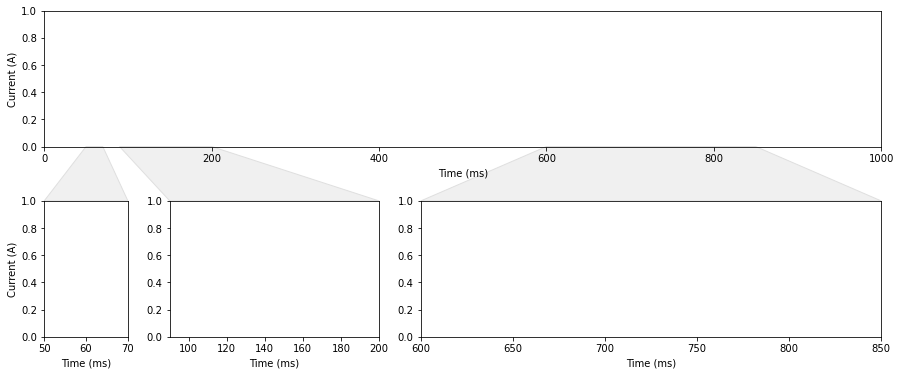

In [4]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 6))
grid = fig.add_gridspec(2, 7, wspace=0.5, hspace=0.4)

ax00 = fig.add_subplot(grid[0, :])
ax00.set_xlabel('Time (ms)')
ax00.set_ylabel('Current (A)')
ax00.set_xlim(0, 1000)

lim0 = 50, 70
ax10 = fig.add_subplot(grid[1, 0])
ax10.set_xlim(*lim0)
ax10.set_xlabel('Time (ms)')
ax10.set_ylabel('Current (A)')
vconnect(ax00, ax10, lim0)

lim1 = 90, 200
ax11 = fig.add_subplot(grid[1, 1:3])
ax11.set_xlabel('Time (ms)')
ax11.set_xlim(*lim1)
vconnect(ax00, ax11, lim1)

lim2 = 600, 850
ax12 = fig.add_subplot(grid[1, 3:])
ax12.set_xlabel('Time (ms)')
ax12.set_xlim(*lim2)
vconnect(ax00, ax12, lim2)

plt.show()

## Beeswarm plot

Matplotlib doesn't have a "beeswarm plot" yet.
You can get these plots from seaborn, but that requires your data to be stored in "pandas dataframes".

[This blog post](https://www.flerlagetwins.com/2020/11/beeswarm.html) explains how swarm plots are derived from histograms. I used it to create the function below:

In [24]:
import numpy as np

def simple_beeswarm(y, nbins=None):
    """
    Returns x coordinates for the points in ``y``, so that plotting ``x`` and
    ``y`` results in a bee swarm plot.
    """
    nbins = len(y) // 6

    # Get upper bounds of bins
    y = np.asarray(y)
    x = np.zeros(len(y))
    ylo = np.min(y)
    yhi = np.max(y)
    dy = (yhi - ylo) / nbins
    ybins = np.linspace(ylo + dy, yhi - dy, nbins - 1)

    # Divide indices into bins
    i = np.arange(len(y))
    ibs = [0] * nbins
    ybs = [0] * nbins
    nmax = 0
    for j, ybin in enumerate(ybins):
        f = y <= ybin
        ibs[j], ybs[j] = i[f], y[f]
        nmax = max(nmax, len(ibs[j]))
        f = ~f
        i, y = i[f], y[f]
    ibs[-1], ybs[-1] = i, y
    nmax = max(nmax, len(ibs[-1]))

    # Assign x indices
    dx = 1 / (nmax // 2)
    for i, y in zip(ibs, ybs):
        if len(i) > 1:
            j = len(i) % 2
            i = i[np.argsort(y)]
            a = i[j::2]
            b = i[j+1::2]
            x[a] = (0.5 + j / 3 + np.arange(len(a))) * dx
            x[b] = (0.5 + j / 3 + np.arange(len(b))) * -dx

    return x

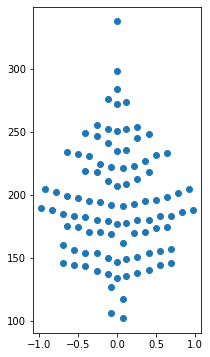

In [26]:
y = np.random.gamma(20, 10, 100)
x = simple_beeswarm(y)

fig = plt.figure(figsize=(3, 6))
ax = fig.add_subplot()
ax.plot(x, y, 'o')
plt.show()

## Rainbow lines

In [one project](https://doi.org/10.1016/j.bpj.2019.08.001), it was helpful to draw lines in changing colours, so that points on one line could be (approximately) connected to another.

In [56]:
def technicolor_dreamline(ax, x, y, z=None, lw=1, colormap='jet'):
    """
    Draws a multi-coloured line.
    """
    x = np.asarray(x)
    y = np.asarray(y)
    if z is not None:
        z = np.asarray(z)

    # Invisible plot for automatic x & y limits
    if z is None:
        ax.plot(x, y, alpha=0)
    else:
        ax.plot(x, y, z, alpha=0)

    # Limit the number of line segments drawn
    n = len(x)
    stride = 1
    if n >= 2000:
        stride = int(len(x) / 1000)
        n = 1 + (len(x) - 1) // stride
            
    # Create collection of line segments
    segments = []
    for i in range(n):
        lo = i * stride
        hi = lo + stride + 1
        xs = x[lo:hi]
        ys = y[lo:hi]
        if z is None:
            segments.append(np.vstack((xs, ys)).T)
        else:
            zs = z[lo:hi]
            segments.append(np.vstack((xs, ys, zs)).T)
    n = len(segments)

    if z is None:
        Collection = matplotlib.collections.LineCollection
    else:
        Collection = Line3DCollection
        
    ax.add_collection(Collection(
        segments,
        cmap=plt.cm.get_cmap(colormap),
        norm=matplotlib.colors.Normalize(0, 1),
        array=np.linspace(0, 1, n),
        lw=lw,
    ))

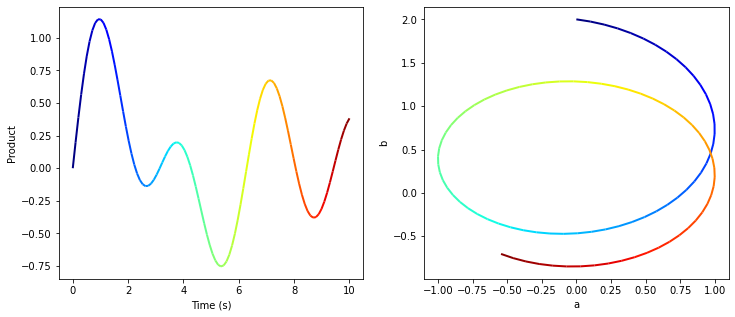

In [61]:
t = np.linspace(0, 10, 100)
a = np.sin(t)
b = np.cos(t) + np.exp(-t / 5)

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Product')
#ax1.plot(t, a * b)
technicolor_dreamline(ax1, t, a * b, lw=2)

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_xlabel('a')
ax2.set_ylabel('b')
#ax2.plot(a, b)
technicolor_dreamline(ax2, a, b, lw=2)

plt.show()